##  CS6910: Fundamentals of Deep Learning
#### Assignment 3 - Team 3

S Renganathan, CH16B058	     
S Nithya, CH16B113		         
Vasistha Singhal, CH16B119

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from io import StringIO
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.data = []
        self.filename = filename
        tar = tarfile.open(folder + '/' + filename)
        for file in tar.getmembers():
            f = tar.extractfile(file)
            if f != None:
                content = pd.read_csv(StringIO(f.read().decode()), sep=' ', header=None).values.ravel()
                self.data.append(content)
            
        self.y = torch.tensor(label_dict[self.filename[:-7]], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [3]:
def train_test_loader(directory, label_dict, train_fraction=0.8, num_workers=2, batch_size=32):

    all_files = list(filter(lambda x: x.endswith('.tar.gz'), os.listdir(directory)))
    files = [file for file in all_files if file[:-7] in label_dict.keys()]
    
    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [4]:
label_dict = {'tallbuilding': 0, 'opencountry':1, 'mountain': 2, 'highway': 3, 'coast': 4}
# trainloader, testloader = train_test_loader('Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)
trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)

In [5]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [6]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
ae1 = AutoEncoder(828, [500, 350, 500])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.0001, momentum=0.9)

In [8]:
old_loss = np.inf
losses = []
max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-4:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 1.9282757287675687
inf
Epoch 2 : Loss = 1.9042146937413647
0.012635673438129703
Epoch 3 : Loss = 1.8799951401623813
0.012882774567646695
Epoch 4 : Loss = 1.8562086956067516
0.012814531368119947
Epoch 5 : Loss = 1.8323880163106054
0.012999800852282133
Epoch 6 : Loss = 1.808037719943307
0.013467803297854804
Epoch 7 : Loss = 1.7828091870654716
0.014151000040201695
Epoch 8 : Loss = 1.75638486309485
0.015044723127515746
Epoch 9 : Loss = 1.72848486087539
0.016141305516167524
Epoch 10 : Loss = 1.698877115141262
0.017427832460775748
Epoch 11 : Loss = 1.6674204604192215
0.018865460433496004
Epoch 12 : Loss = 1.634009564464742
0.020447185060036017
Epoch 13 : Loss = 1.598537480289286
0.02219033623724403
Epoch 14 : Loss = 1.5610025985674425
0.024045367865684442
Epoch 15 : Loss = 1.5215254751118745
0.02594575253671997
Epoch 16 : Loss = 1.4801060747016557
0.027984075680905333
Epoch 17 : Loss = 1.4369517375122414
0.030031862631744562
Epoch 18 : Loss = 1.3922773653810674
0.03208726453

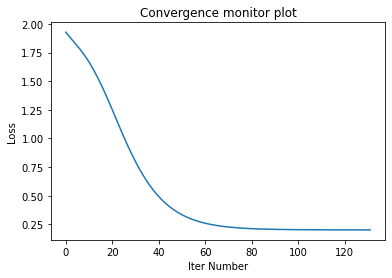

In [9]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [26]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        #self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[1], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))
        #x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(350, [200, 50], 5)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.00001, momentum=0.9)
classifier = classifier.to(device)

In [40]:
old_loss = np.inf

max_epoch = 20000
losses= []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        # extracting encoder features from AE1 to use as input to the MLFFNN
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(Z)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 1e-4 and running_loss<1.05:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Streaming output truncated to the last 5000 lines.
Epoch 2502 : Loss = 1.1050804433497514
0.004336844085961312
Epoch 2503 : Loss = 1.0997032604434271
0.004889667149078073
Epoch 2504 : Loss = 1.1011128263040022
0.0012801284545076177
Epoch 2505 : Loss = 1.1034931513396178
0.0021570818384562852
Epoch 2506 : Loss = 1.1018426621502095
0.0014979354549472326
Epoch 2507 : Loss = 1.1021301868287
0.00026088086682181345
Epoch 2508 : Loss = 1.1034118140285665
0.0011615130303774279
Epoch 2509 : Loss = 1.1010294732722368
0.002163739313216963
Epoch 2510 : Loss = 1.1035311574285682
0.0022669809905148837
Epoch 2511 : Loss = 1.099857519973408
0.003340103048301266
Epoch 2512 : Loss = 1.0995103581385177
0.00031574221408700625
Epoch 2513 : Loss = 1.0989302342588247
0.000527898734248802
Epoch 2514 : Loss = 1.1022521392865614
0.003013743325448913
Epoch 2515 : Loss = 1.101405298168009
0.0007688732930203416
Epoch 2516 : Loss = 1.09994653951038
0.0013262086885406617
Epoch 2517 : Loss = 1.099255697293715
0.00062

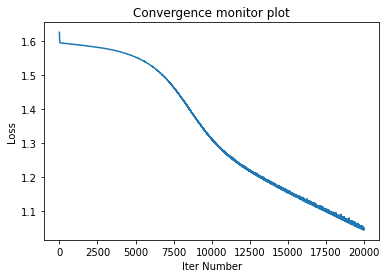

In [41]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [42]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        Z = ae1.get_z(X)
        y_hat = classifier(Z)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.cpu().detach().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 1.0441327095031738


,0,1,2,3,4
0,177,21,69,8,18
1,7,232,30,1,52
2,64,54,140,12,29
3,26,1,5,120,42
4,17,95,27,27,134


In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 0.5703125 Train Precision = 0.5804186824849019 Train F1 = 0.5732925671346372


In [44]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        Z = ae1.get_z(X)
        y_hat = classifier(Z)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 12.67029857635498


,0,1,2,3,4
0,32,9,13,2,7
1,1,65,10,0,12
2,12,22,29,2,10
3,7,5,6,29,19
4,2,29,4,6,19


In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.4943181818181818 Test Precision = 0.5175012722436892 Test F1 = 0.4836580074555261


In [ ]:
torch.save(classifier.state_dict(), 'a2_q1_wts.pt')

# PCA

In [46]:
# To fit the PCA model we load all the training points in a single batch
# train, test = train_test_loader('Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, batch_size=2000, num_workers=0)
train, test, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, batch_size=2000, num_workers=0)

99% Variance Explained: 295


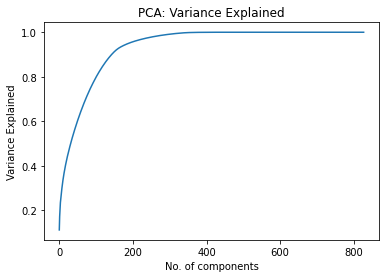

In [47]:
kk = 0
for i in train:
    temp = i[0]

pca1 = PCA(n_components=temp.shape[1])
pca1.fit(temp)

print('99% Variance Explained:', np.where(np.cumsum(pca1.explained_variance_ratio_)>=0.99)[0][0]+1)
explained_var = np.cumsum(pca1.explained_variance_ratio_)
plt.plot(explained_var)
plt.title('PCA: Variance Explained')
plt.xlabel('No. of components')
plt.ylabel('Variance Explained')
plt.show()

In [49]:
def return_pca(temp):
    pca = PCA(n_components=0.99)
    pca.fit(temp)
    return pca

PCA_model = return_pca(temp)

In [51]:
reduced_dimension = PCA_model.transform(temp).shape[1]
pca_clf = FinalNet(reduced_dimension, [150, 50], 5)

In [52]:
reduced_dimension

295

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pca_clf.parameters(), lr=0.001, momentum=0.9)
pca_clf = pca_clf.to(device)

Epoch 1 : Loss = 0.5113905675031921
Epoch 2 : Loss = 0.5035759210586548
Epoch 3 : Loss = 0.49537857689640746
Epoch 4 : Loss = 0.48751894655552774
Epoch 5 : Loss = 0.47988560457121243
Epoch 6 : Loss = 0.4718764322725208
Epoch 7 : Loss = 0.4651388227939606
Epoch 8 : Loss = 0.45846574279395014
Epoch 9 : Loss = 0.45060256360606715
Epoch 10 : Loss = 0.4432249211452224
Epoch 11 : Loss = 0.4359471831809391
Epoch 12 : Loss = 0.42857543514533475
Epoch 13 : Loss = 0.42159939354116277
Epoch 14 : Loss = 0.4153945144604554
Epoch 15 : Loss = 0.40744643285870563
Epoch 16 : Loss = 0.4000686579807239
Epoch 17 : Loss = 0.393373984166167
Epoch 18 : Loss = 0.3871965689415281
Epoch 19 : Loss = 0.38036598773165176
Epoch 20 : Loss = 0.37356085025451413
Epoch 21 : Loss = 0.36648224565115844
Epoch 22 : Loss = 0.3599016097458927
Epoch 23 : Loss = 0.35263247279958276
Epoch 24 : Loss = 0.3463304364545779
Epoch 25 : Loss = 0.3402317406778986
Epoch 26 : Loss = 0.33470577374100685
Epoch 27 : Loss = 0.325683868066831

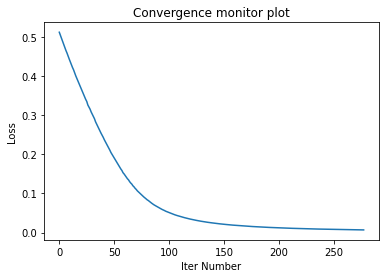

In [56]:
old_loss = np.inf

max_epoch = 500
losses= []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0], data[1].to(device)
        
        # applying PCA on the data to use as input to the MLFFNN
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = pca_clf(Z)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 0.005 and running_loss<0.01:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [62]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0], data[1].to(device)
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        y_hat = pca_clf(Z)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.cpu().detach().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.00685884291306138


,0,1,2,3,4
0,293,0,0,0,0
1,0,322,0,0,0
2,0,0,299,0,0
3,0,0,0,194,0
4,0,0,0,0,300


In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 1.0 Train Precision = 1.0 Train F1 = 1.0


In [61]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0], data[1].to(device)
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        y_hat = pca_clf(Z)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 2.064488649368286


,0,1,2,3,4
0,31,8,20,3,1
1,3,58,11,1,15
2,16,15,34,5,5
3,3,6,8,39,10
4,1,15,5,1,38


In [60]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.5681818181818182 Test Precision = 0.5850483931960001 Test F1 = 0.5704586893070742
